In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
import keras
from keras.models import Sequential
import keras.layers as layers

In [3]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

2025-03-01 12:45:54.439838: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-01 12:45:54.439858: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-03-01 12:45:54.439863: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1740854754.439878 39211244 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740854754.439899 39211244 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/Users/haruiz/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [5]:
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names
print(num_classes)
print(labels)

5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


2025-03-01 12:45:54.577689: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-01 12:45:54.597006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-01 12:45:54.600967: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


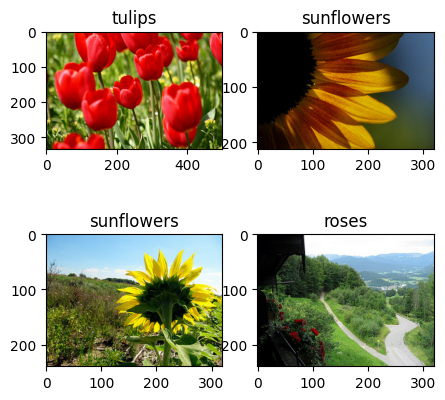

In [6]:
samples = ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    img_array, img_label_idx = img
    ax = fig.add_subplot(2,2, i + 1)
    ax.imshow(img_array)
    ax.set_title(labels[img_label_idx])
plt.show()

In [7]:
IMG_SIZE = 180

resize_and_rescale = Sequential([
    keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    keras.layers.Rescaling(1./255)
])

data_augmentation = Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
])


In [8]:
def prepare_for_training(ds_subset, batch_size = 32, shuffle=False, augment=False):
    ds_subset  =  ds_subset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # shuffle the dataset if needed
    if shuffle:
        ds_subset = ds_subset.shuffle(1000)
    # create data batches
    ds_subset = ds_subset.batch(batch_size)
    # apply data augmentation
    if augment:
        ds_subset= ds_subset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


transformed_ds_train = prepare_for_training(ds_train, shuffle=True, augment=True)
transformed_ds_val = prepare_for_training(ds_validation)
transformed_ds_test = prepare_for_training(ds_test)


2025-03-01 12:45:54.962858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-01 12:45:55.430383: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-01 12:45:55.462095: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


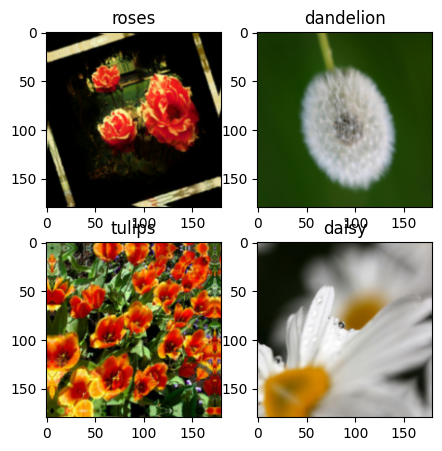

In [9]:
samples = transformed_ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    batch_images, batch_labels = img
    #print(np.min(img_array), np.max(img_array))
    ax = fig.add_subplot(2,2, i + 1)
    ax.imshow(batch_images[0])
    ax.set_title(labels[batch_labels[0]])
plt.show()

In [10]:
model = Sequential([
  layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) ,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model = Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,322,757 (31.75 MB)

 Trainable params: 8,321,285 (31.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [13]:
learning_rate = 0.01  # Set your desired learning rate here
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,322,757 (31.75 MB)

 Trainable params: 8,321,285 (31.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [28]:
epochs=20
training_strategy = tf.distribute.OneDeviceStrategy(device="/gpu:1")
with training_strategy.scope():
    history = model.fit(transformed_ds_train,validation_data=transformed_ds_val, epochs=epochs)

Epoch 1/20


W0000 00:00:1740855248.975588 39211244 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7536 - loss: 0.6506

2025-03-01 12:54:18.015636: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7534 - loss: 0.6508

W0000 00:00:1740855258.566309 39211244 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7533 - loss: 0.6511 - val_accuracy: 0.7439 - val_loss: 0.7919
Epoch 2/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7477 - loss: 0.6631

2025-03-01 12:54:25.099279: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7478 - loss: 0.6631 - val_accuracy: 0.7302 - val_loss: 0.7912
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7458 - loss: 0.6587 - val_accuracy: 0.7493 - val_loss: 0.7472
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7485 - loss: 0.6555

2025-03-01 12:54:37.503692: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7486 - loss: 0.6554 - val_accuracy: 0.7302 - val_loss: 0.8822
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.7597 - loss: 0.6280 - val_accuracy: 0.7302 - val_loss: 0.8717
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7796 - loss: 0.5986 - val_accuracy: 0.6458 - val_loss: 1.0688
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7549 - loss: 0.6380 - val_accuracy: 0.7193 - val_loss: 0.7889
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7723 - loss: 0.5898

2025-03-01 12:55:02.680845: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7722 - loss: 0.5902 - val_accuracy: 0.6294 - val_loss: 1.1351
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7734 - loss: 0.5748 - val_accuracy: 0.7112 - val_loss: 0.8215
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7861 - loss: 0.5635 - val_accuracy: 0.6812 - val_loss: 0.9547
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7787 - loss: 0.6085 - val_accuracy: 0.7057 - val_loss: 0.7548
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7681 - loss: 0.5928 - val_accuracy: 0.7166 - val_loss: 1.0267
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7883 - loss: 0.5401 - val_accuracy: 0.7275 - val_loss: 0.8751
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7656 - loss: 0.5750 - val_accuracy: 0.7520 - val_loss: 0.8188
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8074 - loss: 0.5453 - val_accuracy: 0.7139 - val_lo

2025-03-01 12:55:55.919197: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8040 - loss: 0.5470 - val_accuracy: 0.7302 - val_loss: 0.7870
Epoch 17/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8077 - loss: 0.5130 - val_accuracy: 0.7684 - val_loss: 0.6778
Epoch 18/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8044 - loss: 0.5130 - val_accuracy: 0.7112 - val_loss: 0.8805
Epoch 19/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8106 - loss: 0.5168 - val_accuracy: 0.7411 - val_loss: 0.9225
Epoch 20/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8120 - loss: 0.4777 - val_accuracy: 0.6866 - val_loss: 0.9356


In [15]:
history_dict = history.history
val_acc_values = history_dict['val_accuracy']
train_acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
train_loss_values = history_dict['loss']
epochs_range = range(epochs)

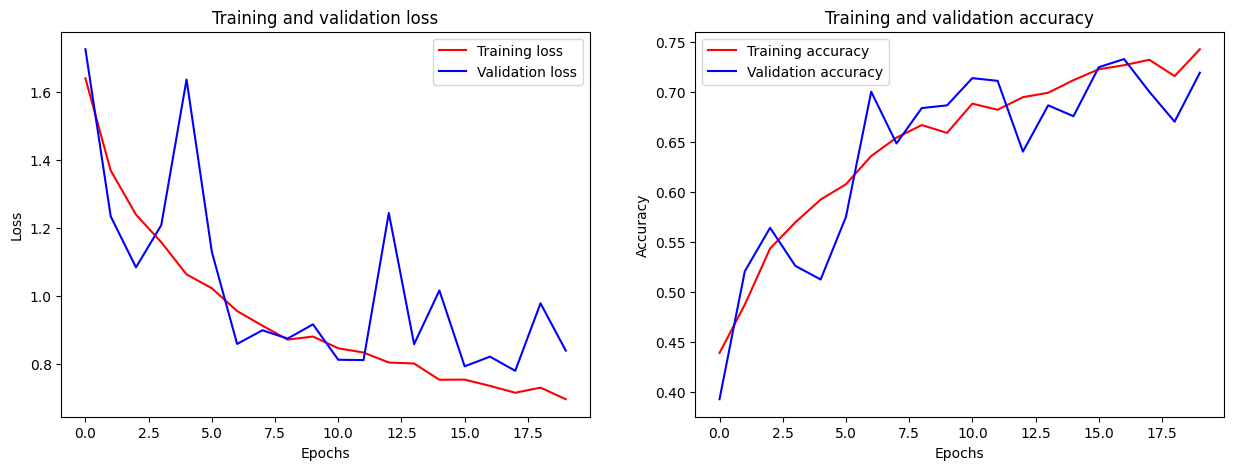

In [16]:
## Plotting the training and validation loss

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, 'r', label='Training loss')
plt.plot(epochs_range, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Plotting the training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_values, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


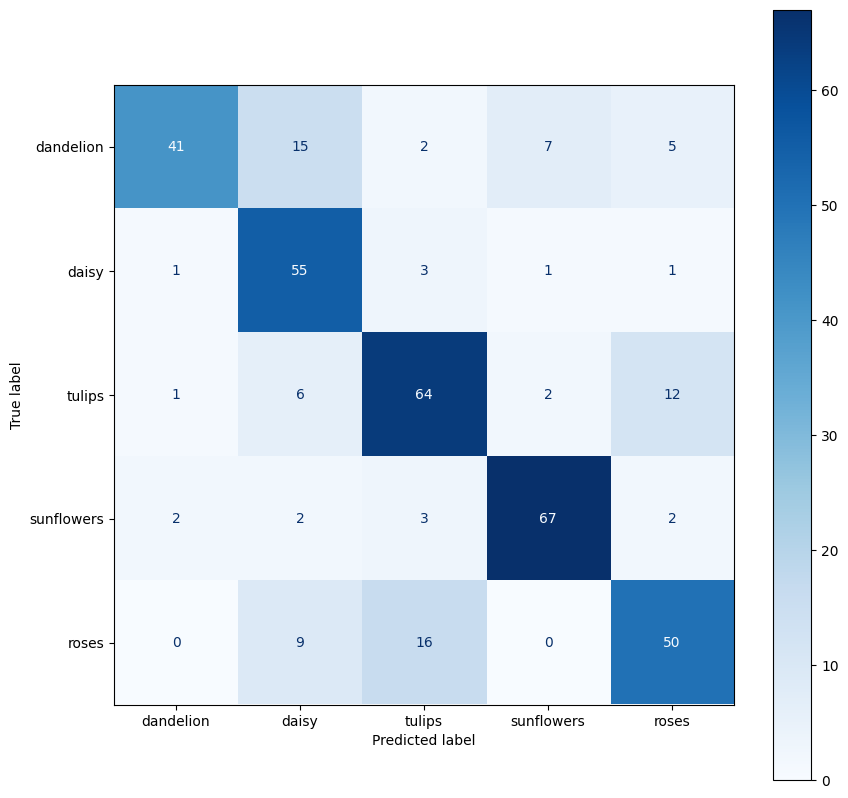

In [17]:
## create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y = [labels for imgs, labels in tfds.as_numpy(transformed_ds_test.unbatch())]
y_pred_probs = model.predict(transformed_ds_test)
y_pred = np.argmax(y_pred_probs, axis=1)


fig, _ = plt.subplots(nrows=1, figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cf = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.show()

In [18]:
from pathlib import Path

image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDsfjyxj9FdLd8KAjDFvSWTp69rvC_n9rYCg&s"
image_name = Path(image_url).name
image_path = tf.keras.utils.get_file(image_name, image_url)
img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

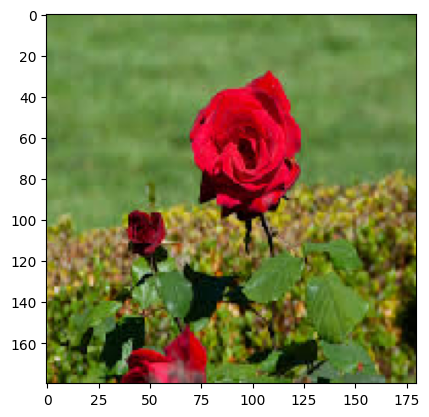

In [19]:
plt.imshow(img)

In [20]:
import numpy as np
img_array = tf.keras.preprocessing.image.img_to_array(img)
print(np.min(img_array), np.max(img_array))
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.expand_dims(img_tensor, 0)
img_tensor = tf.divide(img_tensor, 255.0)
scores = model(img_tensor)
probs = tf.nn.softmax(scores).numpy().squeeze()
class_idx = np.argmax(probs)
print(f"this image was classified as {labels[class_idx]} with a probability of {probs[class_idx]}")

for i in range(len(probs)):
    print(f"{labels[i]}: {probs[i]:.3f}")

0.0 255.0
this image was classified as tulips with a probability of 0.4323970675468445
dandelion: 0.076
daisy: 0.052
tulips: 0.432
sunflowers: 0.160
roses: 0.279


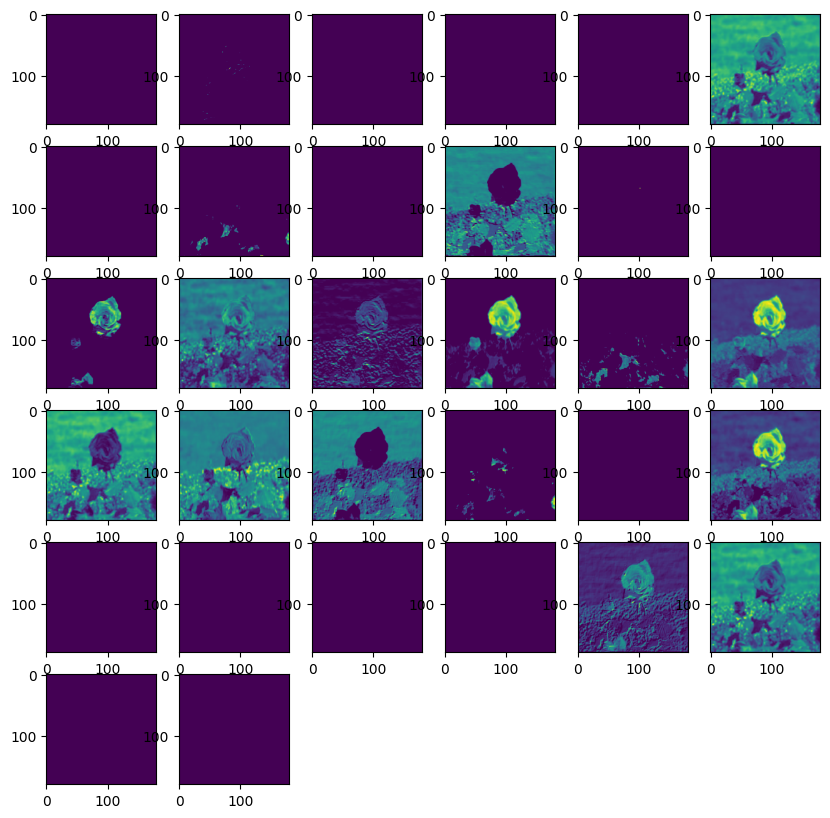

In [21]:
import math
cnn_layers = [layer for layer in model.layers  if isinstance(layer, layers.Conv2D)]
selected_layers = cnn_layers[:1]
features_extraction_model = Sequential(selected_layers)
features_map = features_extraction_model(img_tensor).numpy().squeeze()
num_fmaps = features_map.shape[-1]
num_rows = math.ceil(num_fmaps / 6)
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(num_rows, 6, i + 1)
    ax.grid(False)
    ax.imshow(fmap, cmap='viridis')
plt.show()

In [22]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (1, 180, 180, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,965,329 (95.24 MB)

 Trainable params: 8,321,285 (31.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 16,642,572 (63.49 MB)

Layer name: max_pooling2d_6, layer index: 11


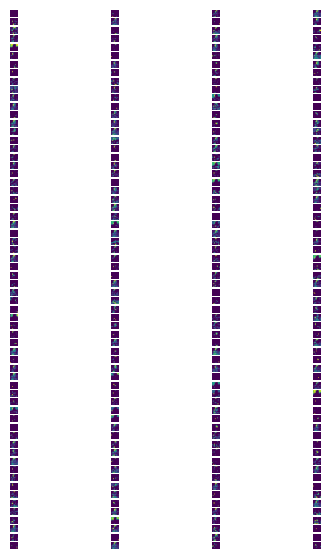

In [29]:
layers_index = {layer.name: i for i, layer in enumerate(model.layers)}
layer_name = "max_pooling2d_6"
layer_index = layers_index[layer_name]
print(f"Layer name: {layer_name}, layer index: {layer_index}")
features_extraction_model = tf.keras.Sequential(model.layers[:layer_index + 1])
features_map = features_extraction_model(img_tensor).numpy().squeeze()

# Plot the feature maps
fig = plt.figure(figsize=(5, 7))
num_images = features_map.shape[-1]
num_cols = 4
num_rows = math.ceil(num_images / num_cols)
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    ax.grid(False)
    ax.set_axis_off()
    ax.imshow(fmap, cmap='viridis')
plt.show()

In [30]:
from pathlib import Path
MODELS_DIR = Path("flowers-model")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
TF_MODEL_PATH = MODELS_DIR.joinpath("model.keras")
model.save(TF_MODEL_PATH)